In [ ]:
# 加载包
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.datasets import fetch_olivetti_faces
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# 加载数据集
olivetti_faces = fetch_olivetti_faces(shuffle=True)
X, y = olivetti_faces.data, olivetti_faces.target

In [5]:
# 转换为pytorch张量
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [6]:
# 划分训练集和测试集
train_size = int(0.8 * len(X_tensor))
test_size = len(X_tensor) - train_size
train_dataset, test_dataset = random_split(TensorDataset(X_tensor, y_tensor), [train_size, test_size])

In [7]:
# 数据加载器
BATCH_SIZE = 8  
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
# 定义神经网络模型
class FaceNN(nn.Module):
    def __init__(self, activation_fn=nn.ReLU()):
        super(FaceNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(4096, 512),
            nn.BatchNorm1d(512),
            activation_fn,
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            activation_fn,
            nn.Linear(256, 40) 
        )
    
    def forward(self, x):
        return self.model(x)

In [9]:
# 训练函数
def train_model(model, train_loader, epochs=20, lr=0.01):
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    train_hist = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
        train_hist.append(avg_loss)

    return train_hist


In [10]:
# 测试函数
def test_acc(test_loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    acc = correct / total * 100
    print(f"Test Accuracy: {acc:.2f}%")
    return acc

In [11]:
# 训练不同模型
print("\nTraining Model 1 (Sigmoid Activation)")
model1 = FaceNN(activation_fn=nn.Sigmoid()).to(device)
model1_hist = train_model(model1, train_loader, epochs=10)

print("\nTraining Model 2 (ReLU Activation)")
model2 = FaceNN(activation_fn=nn.ReLU()).to(device)
model2_hist = train_model(model2, train_loader, epochs=10)

print("\nTraining Model 3 (Simplified ReLU Model)")
model3 = nn.Sequential(
    nn.Linear(4096, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 40)
).to(device)
model3_hist = train_model(model3, train_loader, epochs=10)


Training Model 1 (Sigmoid Activation)
Epoch [1/10], Loss: 3.3974
Epoch [2/10], Loss: 2.6809
Epoch [3/10], Loss: 1.9739
Epoch [4/10], Loss: 1.5349
Epoch [5/10], Loss: 1.1452
Epoch [6/10], Loss: 0.7923
Epoch [7/10], Loss: 0.5695
Epoch [8/10], Loss: 0.3991
Epoch [9/10], Loss: 0.2969
Epoch [10/10], Loss: 0.2324

Training Model 2 (ReLU Activation)
Epoch [1/10], Loss: 3.0522
Epoch [2/10], Loss: 1.5226
Epoch [3/10], Loss: 0.7126
Epoch [4/10], Loss: 0.3678
Epoch [5/10], Loss: 0.2502
Epoch [6/10], Loss: 0.1768
Epoch [7/10], Loss: 0.0979
Epoch [8/10], Loss: 0.0503
Epoch [9/10], Loss: 0.0428
Epoch [10/10], Loss: 0.0489

Training Model 3 (Simplified ReLU Model)
Epoch [1/10], Loss: 2.6505
Epoch [2/10], Loss: 0.9305
Epoch [3/10], Loss: 0.3213
Epoch [4/10], Loss: 0.1596
Epoch [5/10], Loss: 0.0890
Epoch [6/10], Loss: 0.0493
Epoch [7/10], Loss: 0.0701
Epoch [8/10], Loss: 0.0315
Epoch [9/10], Loss: 0.0373
Epoch [10/10], Loss: 0.0230


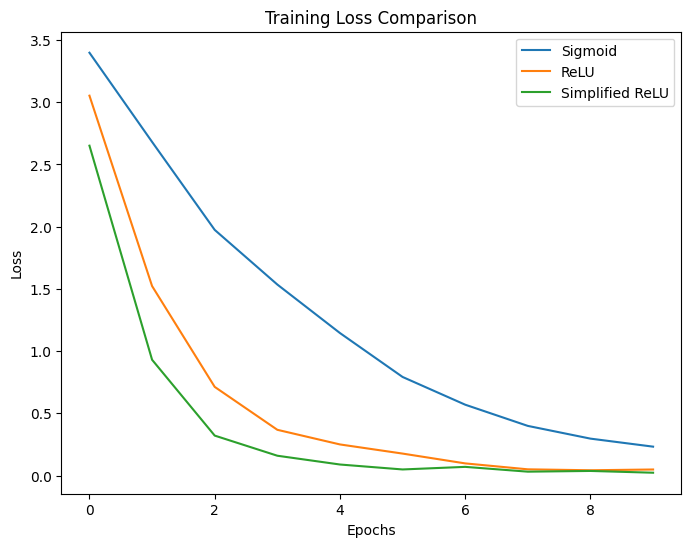

In [12]:
# 画出loss下降曲线
plt.figure(figsize=(8, 6))
plt.plot(model1_hist, label="Sigmoid")
plt.plot(model2_hist, label="ReLU")
plt.plot(model3_hist, label="Simplified ReLU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()

In [13]:
# 评估准确率
print("\nEvaluating Model 1 (Sigmoid)")
test_acc(test_loader, model1)

print("\nEvaluating Model 2 (ReLU)")
test_acc(test_loader, model2)

print("\nEvaluating Model 3 (Simplified ReLU)")
test_acc(test_loader, model3)


Evaluating Model 1 (Sigmoid)
Test Accuracy: 96.25%

Evaluating Model 2 (ReLU)
Test Accuracy: 96.25%

Evaluating Model 3 (Simplified ReLU)
Test Accuracy: 98.75%


98.75